# Modeling

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
import pandas as pd
from scipy.io import arff
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from scipy.stats import randint
from scipy.fft import fft, fftfreq
import numpy as np
import librosa

In [2]:

from scipy.fft import rfft, rfftfreq

def extract_features_v2(signal: np.ndarray) -> dict:
    fft_values = np.abs(rfft(signal))
    fft_freqs = rfftfreq(len(signal), 1 / 6000)
    mfcc = librosa.feature.mfcc(y=signal, sr=6000, n_mfcc=13)

    return fft_values.tolist() + mfcc.flatten().tolist()


def build_feature_df_v2(df_in: pd.DataFrame) -> pd.DataFrame: 
    rows = [] 
    for row in df_in.itertuples(index=False): 
        signal = np.asarray(row, dtype=float) 
        feats = extract_features_v2(signal) 
        rows.append(feats)
        
    return pd.DataFrame(rows)


In [4]:
data_train, meta_train = arff.loadarff('./InsectSound/InsectSound_TRAIN.arff')
data_test, meta_test = arff.loadarff('./InsectSound/InsectSound_TEST.arff')

df_raw_train = pd.DataFrame(data_train)
df_raw_test = pd.DataFrame(data_test)

df_raw_train['target'] = df_raw_train['target'].str.decode('utf-8')
df_raw_test['target'] = df_raw_test['target'].str.decode('utf-8')

In [5]:
df_raw_test.drop('target', axis=1).to_csv('tester.csv')

In [4]:
y_train = df_raw_train['target']
y_test = df_raw_test['target']

df_train = build_feature_df_v2(df_raw_train.drop(columns=['target'])) 
df_test = build_feature_df_v2(df_raw_test.drop(columns=['target']))

C:\Users\grubg\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=600
  warnings.warn(
C:\Users\grubg\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=600
  warnings.warn(


In [5]:
def get_svm_pipeline(class_weight='balanced'):
    """Pipeline: Scaling -> SVM RBF"""
    return Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=1.0, probability=True, 
                    class_weight=class_weight, random_state=42))
    ])

In [6]:
new_data1 = df_train.copy()
new_data1['target'] = y_train

new_test1 = df_test.copy()
new_test1['target'] = y_test

new_data1['target'] = new_data1['target'].map(lambda x: 'Fly' if 'stigma' in x or 'flies' in x else 'female_mos' if 'female' in x else 'male_mos')

new_data1['target'].unique()    

array(['female_mos', 'male_mos', 'Fly'], dtype=object)

In [7]:
new_data1 = df_train.copy()
new_data1['target'] = y_train

new_test1 = df_test.copy()
new_test1['target'] = y_test

new_data1['target'] = new_data1['target'].map(lambda x: 'Fly' if 'stigma' in x or 'flies' in x else 'female_mos' if 'female' in x else 'male_mos')

new_test1['target'] = new_test1['target'].map(lambda x: 'Fly' if 'stigma' in x or 'flies' in x else 'female_mos' if 'female' in x else 'male_mos')

new_data1['target'].unique()    

model_level1 = get_svm_pipeline(class_weight='balanced')
model_level1.fit(new_data1.drop(columns=['target']), new_data1['target'])

y_pred = model_level1.predict(new_test1.drop(columns=['target']))
print(classification_report(new_test1['target'], y_pred))

              precision    recall  f1-score   support

         Fly       0.89      0.95      0.92      5000
  female_mos       0.98      0.93      0.96     10000
    male_mos       0.97      0.98      0.97     10000

    accuracy                           0.95     25000
   macro avg       0.94      0.95      0.95     25000
weighted avg       0.96      0.95      0.95     25000



<Axes: >

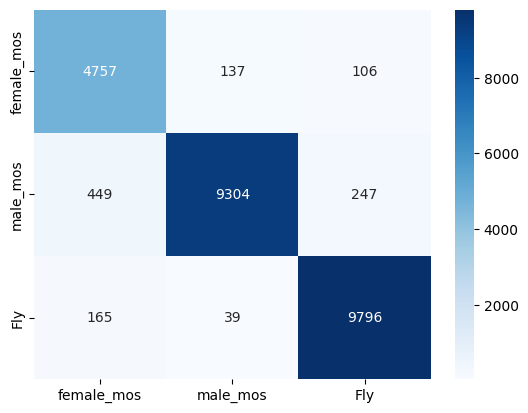

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix(new_test1['target'], y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['female_mos', 'male_mos', 'Fly'], yticklabels=['Fly', 'female_mos', 'male_mos'])

In [10]:
new_data2 = df_train.copy()
new_data2['target'] = y_train

new_test2 = df_test.copy()
new_test2['target'] = y_test

female_mosquito = ['Aedes_female', 'Quinx_female', 'Tarsalis_female']

new_data2 = new_data2[new_data2['target'].isin(female_mosquito)]
new_test2 = new_test2[new_test2['target'].isin(female_mosquito)]

model_female = get_svm_pipeline(class_weight='balanced')
model_female.fit(new_data2.drop(columns=['target']), new_data2['target'])

y_pred = model_female.predict(new_test2.drop(columns=['target']))

print(classification_report(new_test2['target'], y_pred))

                 precision    recall  f1-score   support

   Aedes_female       0.79      0.71      0.75      2500
   Quinx_female       0.72      0.79      0.75      2500
Tarsalis_female       0.95      0.95      0.95      2500

       accuracy                           0.82      7500
      macro avg       0.82      0.82      0.82      7500
   weighted avg       0.82      0.82      0.82      7500



<Axes: >

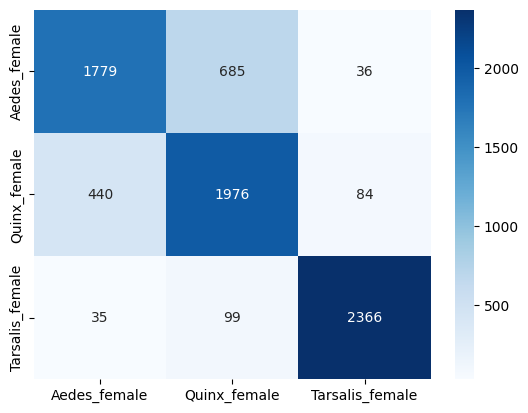

In [11]:
import seaborn as sns
sns.heatmap(confusion_matrix(new_test2['target'], y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=female_mosquito, yticklabels=female_mosquito)

In [12]:
new_data2 = df_train.copy()
new_data2['target'] = y_train

new_test2 = df_test.copy()
new_test2['target'] = y_test

qva = ['Aedes_female', 'Quinx_female']

new_data2 = new_data2[new_data2['target'].isin(qva)]
new_test2 = new_test2[new_test2['target'].isin(qva)]

model_avq = get_svm_pipeline(class_weight='balanced')

model_avq.fit(new_data2.drop(columns=['target']), new_data2['target'])

y_pred = model_avq.predict(new_test2.drop(columns=['target']))
print(classification_report(new_test2['target'], y_pred))

              precision    recall  f1-score   support

Aedes_female       0.80      0.72      0.76      2500
Quinx_female       0.74      0.82      0.78      2500

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000



<Axes: >

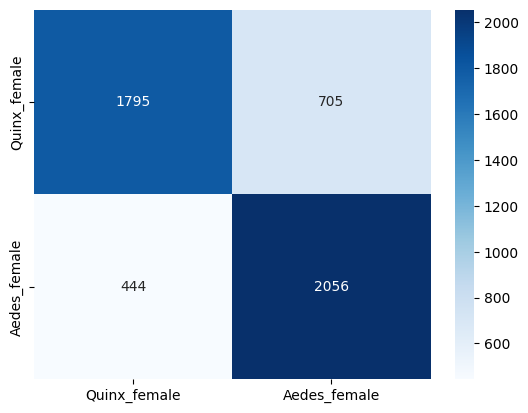

In [13]:
sns.heatmap(confusion_matrix(new_test2['target'], y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Quinx_female', 'Aedes_female'], yticklabels=['Quinx_female', 'Aedes_female'])

In [14]:
new_data2 = df_train.copy()
new_data2['target'] = y_train

new_test2 = df_test.copy()
new_test2['target'] = y_test

male = ['Aedes_male', 'Quinx_male', 'Tarsalsis_male']

new_data2 = new_data2[new_data2['target'].isin(male)]
new_test2 = new_test2[new_test2['target'].isin(male)]

model_male = get_svm_pipeline(class_weight='balanced')

model_male.fit(new_data2.drop(columns=['target']), new_data2['target'])

y_pred = model_male.predict(new_test2.drop(columns=['target']))
print(classification_report(new_test2['target'], y_pred))

              precision    recall  f1-score   support

  Aedes_male       0.91      0.92      0.92      2500
  Quinx_male       0.92      0.91      0.92      2500

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



In [15]:
new_data2 = df_train.copy()
new_data2['target'] = y_train

new_test2 = df_test.copy()
new_test2['target'] = y_test

fly = ['Stigma_male', 'Stigma_female', 'House_flies', 'Fruit_flies']

new_data2 = new_data2[new_data2['target'].isin(fly)]
new_test2 = new_test2[new_test2['target'].isin(fly)]

model_fly = get_svm_pipeline(class_weight='balanced')

model_fly.fit(new_data2.drop(columns=['target']), new_data2['target'])

y_pred = model_fly.predict(new_test2.drop(columns=['target']))

print(classification_report(new_test2['target'], y_pred))

               precision    recall  f1-score   support

  Fruit_flies       0.83      0.80      0.81      2500
  House_flies       0.82      0.85      0.84      2500
Stigma_female       0.93      0.93      0.93      2500
  Stigma_male       0.98      0.97      0.98      2500

     accuracy                           0.89     10000
    macro avg       0.89      0.89      0.89     10000
 weighted avg       0.89      0.89      0.89     10000



In [16]:
# new_data2 = df_train.copy()
# new_data2['target'] = y_train   
# new_test2 = df_test.copy()
# new_test2['target'] = y_test

# model = get_svm_pipeline(class_weight='balanced')
# model.fit(new_data2.drop(columns=['target']), new_data2['target'])
# y_pred = model.predict(new_test2.drop(columns=['target']))
# print(classification_report(new_test2['target'], y_pred))

                precision    recall  f1-score   support

   Aedes_female       0.72      0.64      0.68      2500
     Aedes_male       0.86      0.91      0.89      2500
    Fruit_flies       0.80      0.79      0.79      2500
    House_flies       0.77      0.83      0.80      2500
   Quinx_female       0.67      0.66      0.66      2500
     Quinx_male       0.66      0.63      0.65      2500
  Stigma_female       0.62      0.74      0.67      2500
    Stigma_male       0.80      0.87      0.83      2500
Tarsalis_female       0.89      0.79      0.84      2500
  Tarsalis_male       0.65      0.57      0.61      2500

       accuracy                           0.74     25000
      macro avg       0.74      0.74      0.74     25000
   weighted avg       0.74      0.74      0.74     25000


In [19]:
import joblib
joblib.dump(model_level1, 'model_level1.pkl')
joblib.dump(model_female, 'model_female.pkl')
joblib.dump(model_avq, 'model_avq.pkl')
joblib.dump(model_male, 'model_male.pkl')
joblib.dump(model_fly, 'model_fly.pkl')

['model_fly.pkl']

In [31]:
class SequentialMosquitoClassifier:
    def __init__(self, all_models):
        self.models = all_models

    def predict(self, X):
        predictions = []

        for index, row in X.iterrows():
            sample = row.values.reshape(1, -1)
            # First level: Fly vs Mosquito
            level1_pred = self.models['level1'].predict(sample)[0]
            if level1_pred == 'Fly':
                predictions.append(self.predict_fly_species(sample)[0])
            elif level1_pred == 'female_mos':
                # Second level: Female Mosquito Species
                level2_pred = self.predict_female_mosquito(sample)[0]
                if level2_pred in ['Aedes_female', 'Quinx_female']:
                    predictions.append(self.predict_quinx_vs_aedes(sample)[0])
                else:
                    predictions.append(level2_pred)
            elif level1_pred == 'male_mos':
                # Second level: Male Mosquito Species
                level2_pred = self.predict_male_mosquito(sample)[0]
                predictions.append(level2_pred)
        return predictions
    
    def predict_female_mosquito(self, X):  
        predictions = self.models['fem_mos'].predict(X)
        return predictions

    def predict_quinx_vs_aedes(self, X):
        predictions = self.models['avq'].predict(X)
        return predictions

    def predict_male_mosquito(self, X):
        predictions = self.models['male_mos'].predict(X)
        return predictions
    
    def predict_fly_species(self, X):
        predictions = self.models['fly_species'].predict(X)
        return predictions

In [32]:
# Inisialisasi Class dengan model SVM
svm_classifier = SequentialMosquitoClassifier({
    'level1' : model_level1,
    'fem_mos' : model_female,
    'avq' : model_avq,
    'male_mos' : model_male,
    'fly_species' : model_fly
})

# Lakukan Prediksi pada data Test
# Pastikan X_test hanya berisi fitur (angka), tanpa label
print("Memulai prediksi SVM Berjenjang...")
y_pred_svm = svm_classifier.predict(df_test)

# Lihat Hasil


Memulai prediksi SVM Berjenjang...
